The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Redes Adversariais Gerativas Convolucionais Profundas
:label:`sec_dcgan`

Em :numref:`sec_basic_gan`, apresentamos as idéias básicas por trás de como funcionam os GANs. Mostramos que eles podem extrair amostras de alguma distribuição simples e fácil de amostrar, como uma distribuição uniforme ou normal, e transformá-los em amostras que parecem corresponder à distribuição de algum conjunto de dados. E embora nosso exemplo de correspondência de uma distribuição gaussiana 2D tenha chegado ao ponto, não é especialmente empolgante.

Nesta seção, demonstraremos como você pode usar GANs para gerar imagens fotorrealísticas. Estaremos baseando nossos modelos nos GANs convolucionais profundos (DCGAN) introduzidos em :cite:`Radford.Metz.Chintala.2015`. Vamos tomar emprestada a arquitetura convolucional que se mostrou tão bem-sucedida para problemas discriminativos de visão de computador e mostrar como, por meio de GANs, eles podem ser aproveitados para gerar imagens fotorrealistas.


In [1]:
import warnings
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## O *Dataset* de Pokémon

O *dataset* que usaremos é uma coleção de sprites Pokémon obtidos em [pokemondb](https://pokemondb.net/sprites). Primeiro baixe, extraia e carregue este conjunto de dados.


In [2]:
#@save
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

Redimensionamos cada imagem em $64\times 64$. A transformação `ToTensor` projetará o valor do pixel em $[0, 1]$, enquanto nosso gerador usará a função tanh para obter saídas em $[-1, 1]$. Portanto, normalizamos os dados com $0,5$ de média e $0,5$ de desvio padrão para corresponder ao intervalo de valores.


In [3]:
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

Vamos visualizar as primeiras 20 imagens.


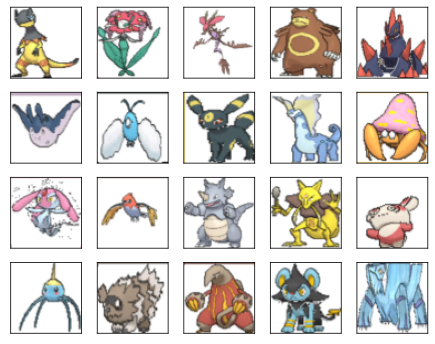

In [4]:
warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

## O Gerador

O gerador precisa mapear a variável de ruído$\mathbf z\in\mathbb R^d$, um vetor comprimento $d$, para uma imagem RGB com largura e altura $64\times 64$. Em :numref:`sec_fcn` introduzimos a rede totalmente convolucional que usa a camada de convolução transposta (consulte :numref:`sec_transposed_conv`) para aumentar o tamanho da entrada. O bloco básico do gerador contém uma camada de convolução transposta seguida pela normalização do lote e ativação ReLU.


In [5]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

Por padrão, a camada de convolução transposta usa um kernel $k_h = k_w = 4$, passos $s_h = s_w = 2$ e um preenchimento $p_h = p_w = 1$. Com uma forma de entrada de $n_h^{'} \times n_w^{'} = 16 \times 16$, o bloco gerador dobrará a largura e a altura da entrada.

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= [(n_h k_h - (n_h-1)(k_h-s_h)- 2p_h] \times [(n_w k_w - (n_w-1)(k_w-s_w)- 2p_w]\\
  &= [(k_h + s_h (n_h-1)- 2p_h] \times [(k_w + s_w (n_w-1)- 2p_w]\\
  &= [(4 + 2 \times (16-1)- 2 \times 1] \times [(4 + 2 \times (16-1)- 2 \times 1]\\
  &= 32 \times 32 .\\
\end{aligned}
$$


In [6]:
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape

torch.Size([2, 20, 32, 32])

Se alterar a camada de convolução transposta para um kernel $4\times 4$ kernel, passos $1\times 1$ e preenchimento zero. Com um tamanho de entrada de $1 \times 1$, a saída terá sua largura e altura aumentadas em 3, respectivamente.


In [7]:
x = torch.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk(x).shape

torch.Size([2, 20, 4, 4])

O gerador consiste em quatro blocos básicos que aumentam a largura e a altura da entrada de 1 para 32. Ao mesmo tempo, ele primeiro projeta a variável latente em canais $64\times 8$ e, em seguida, divide os canais a cada vez. Por fim, uma camada de convolução transposta é usada para gerar a saída. Ele ainda dobra a largura e a altura para corresponder à forma desejada de $64\times 64$ e reduz o tamanho do canal para $3$. A função de ativação tanh é aplicada aos valores de saída do projeto na faixa $(-1, 1)$.


In [8]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8,
            strides=1, padding=0),                  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 64, 64)

Gere uma variável latente de 100 dimensões para verificar a forma de saída do gerador.


In [9]:
x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

## Discriminador

O discriminador é uma rede de rede convolucional normal, exceto que usa um ReLU com vazamento como sua função de ativação. Dado $\alpha \in[0, 1]$, sua definição é

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

Como pode ser visto, é um ReLU normal se $\alpha=0$, e uma função de identidade se $\alpha=1$. Para $\alpha \in (0, 1)$, o ReLU com vazamento é uma função não linear que fornece uma saída diferente de zero para uma entrada negativa. Seu objetivo é corrigir o problema de "ReLU agonizante" de que um neurônio pode sempre produzir um valor negativo e, portanto, não pode fazer nenhum progresso, pois o gradiente de ReLU é 0.


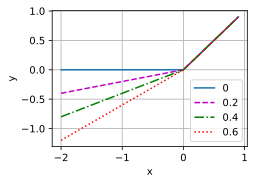

In [10]:
alphas = [0, .2, .4, .6, .8, 1]
x = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).detach().numpy() for alpha in alphas]
d2l.plot(x.detach().numpy(), Y, 'x', 'y', alphas)

O bloco básico do discriminador é uma camada de convolução seguida por uma camada de normalização em lote e uma ativação ReLU com vazamento. Os hiperparâmetros da camada de convolução são semelhantes à camada de convolução transposta no bloco gerador.


In [11]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

Um bloco básico com configurações padrão reduzirá pela metade a largura e a altura das entradas, como demonstramos em :numref:`sec_padding`. Por exemplo, dada uma forma de entrada $n_h = n_w = 16$, com uma forma de kernel $k_h = k_w = 4$, uma forma de passo $s_h = s_w = 2$ e uma forma de preenchimento $p_h = p_w = 1$, a forma de saída será:

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= \lfloor(n_h-k_h+2p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+2p_w+s_w)/s_w\rfloor\\
  &= \lfloor(16-4+2\times 1+2)/2\rfloor \times \lfloor(16-4+2\times 1+2)/2\rfloor\\
  &= 8 \times 8 .\\
\end{aligned}
$$


In [12]:
x = torch.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk(x).shape

torch.Size([2, 20, 8, 8])

O discriminador é um espelho do gerador.


In [13]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)

Ele usa uma camada de convolução com canal de saída $1$ como a última camada para obter um único valor de predição.


In [14]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

## Treinamento

Comparado ao GAN básico em :numref:`sec_basic_gan`, usamos a mesma taxa de aprendizado para o gerador e o discriminador, uma vez que são semelhantes entre si. Além disso, alteramos $\beta_1$ em Adam (:numref:`sec_adam`) de $0,9$ para $0,5$. Ele diminui a suavidade do momentum, a média móvel exponencialmente ponderada dos gradientes anteriores, para cuidar dos gradientes que mudam rapidamente porque o gerador e o discriminador lutam um com o outro. Além disso, o ruído gerado aleatoriamente `Z`, é um tensor 4-D e estamos usando GPU para acelerar o cálculo.


In [15]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

Treinamos o modelo com um pequeno número de épocas apenas para demonstração.
Para melhor desempenho,
a variável `num_epochs` pode ser definida para um número maior.


loss_D 0.281, loss_G 6.224, 1057.2 examples/sec on cuda:0


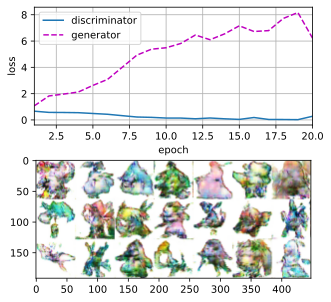

In [16]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

## Resumo

* A arquitetura DCGAN tem quatro camadas convolucionais para o Discriminador e quatro camadas convolucionais "com passos fracionários" para o Gerador.
* O Discriminador é um conjunto de convoluções de 4 camadas com normalização em lote (exceto sua camada de entrada) e ativações ReLU com vazamento.
* ReLU com vazamento é uma função não linear que fornece uma saída diferente de zero para uma entrada negativa. Ele tem como objetivo corrigir o problema do “ReLU agonizante” e ajudar os gradientes a fluírem mais facilmente pela arquitetura.

## Exercícios

1. O que acontecerá se usarmos a ativação ReLU padrão em vez de ReLU com vazamento?
2. Aplique DCGAN no Fashion-MNIST e veja qual categoria funciona bem e qual não funciona.


[Discussões](https://discuss.d2l.ai/t/1083)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTU3MjIwNzI1OSwtMTUzODU4NTEzNiwtMT
E4ODU3MTk4OCwtMTQ3NjY3NjkwNCw1OTYxMDIwNDQsLTM3NzE2
NDg1MywxMTQ4ODQ5Mjc5LDE0Mjk5NzE1MjFdfQ==
-->
